<a href="https://colab.research.google.com/github/vikaspathak0911/Plain-CNN-vs-ResNet-/blob/main/plain_CNN_vs_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
file = "/content/cifar-10-python.tar.gz"
# Path to the CIFAR-10 dataset tarball that was downloaded.
# CIFAR-10 is provided as a compressed `.tar.gz` archive containing pickled batches.

# Extract to /content/cifar-10-batches-py
with tarfile.open(file, "r:gz") as tar:
    # Open the tar.gz file in read mode ("r:gz" → read + gzip compressed).

    tar.extractall(path="/content")
    # Extract all the contents into /content directory.
    # This will create a folder `/content/cifar-10-batches-py`
    # containing data files like:
    #   - data_batch_1, data_batch_2, ..., data_batch_5  (training data)
    #   - test_batch  (testing data)
    #   - batches.meta (metadata about labels)

    # Why this step is important:
    # CIFAR-10 is not directly in image format here.
    # It's stored as serialized Python objects (pickled dictionaries).
    # We need to extract these first before we can load them into NumPy arrays
    # or feed them into a CNN/ResNet model.


/tmp/ipython-input-2677686743.py:9: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path="/content")


In [37]:
import os  # For interacting with the file system (listing directories, paths, etc.)

print(os.listdir("/content/cifar-10-batches-py"))
# os.listdir() lists all files inside the extracted CIFAR-10 directory.
# Expected output:
#   ['data_batch_1', 'data_batch_2', ..., 'data_batch_5',
#    'test_batch', 'batches.meta']
#
# - data_batch_1 to data_batch_5 → Training data (each batch has 10,000 images).
# - test_batch → Test data (10,000 images).
# - batches.meta → Metadata (e.g., label names like "airplane", "cat", etc.).
#
# Why this step is important:
# We confirm that extraction worked correctly and the dataset files
# are available before attempting to load and preprocess them.


['data_batch_1', 'batches.meta', 'data_batch_3', 'data_batch_4', 'test_batch', 'readme.html', 'data_batch_5', 'data_batch_2']


In [38]:
import pickle   # For loading the CIFAR-10 batches (stored as Python pickled dictionaries)
import numpy as np  # For numerical operations (reshaping, normalizing, etc.)

def unpickle(file):
    """
    Load a CIFAR-10 batch file.

    Args:
        file (str): Path to the batch file.

    Returns:
        dict: A dictionary containing the data, labels, and filenames.
    """
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        # Each CIFAR-10 file is a pickled Python dict with byte-string keys.
    return dict

# Example: Load the first batch of CIFAR-10 training data
batch1 = unpickle("cifar-10-batches-py/data_batch_1")

# Inspect the keys in the loaded dictionary
print(batch1.keys())
# Expected keys:
#   b'data'      → Image data (10000 samples, each a flattened 3072-dim vector: 32x32x3).
#   b'labels'    → List of numeric class labels (0–9).
#   b'filenames' → Filenames of the images (not always needed for training).
#
# Why this step matters:
# CIFAR-10 images are not stored as .jpg or .png — they're serialized as raw arrays.
# Unpickling converts them back into Python objects (NumPy arrays + labels),
# which we can then preprocess into a format suitable for CNN/ResNet training.


dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [39]:
# Extract image data and labels from the loaded batch
X = batch1[b'data']      # Shape: (10000, 3072) → 10,000 images, each flattened to 3072 values
Y = batch1[b'labels']    # List of 10,000 integer labels (range 0–9, one for each image)

# Reshape the data to image format
X = X.reshape(-1, 3, 32, 32)   # Reshape to (num_images, channels, height, width)
# Now: (10000, 3, 32, 32)

X = X.transpose(0, 2, 3, 1)    # Rearrange axes to (num_images, height, width, channels)
# Now: (10000, 32, 32, 3), which is the standard format for TensorFlow/Keras
# (TensorFlow expects channels-last ordering: H × W × C).

print("Image shape:", X[0].shape)  # Output: (32, 32, 3) → a single image

# Why this step is important:
# - CIFAR-10 stores images as flattened vectors (3*32*32 = 3072).
# - CNNs expect inputs in image tensor format (H, W, C).
# - This reshaping + transpose operation converts raw data into actual RGB images,
#   making them ready for visualization, normalization, and feeding into CNN/ResNet models.


Image shape: (32, 32, 3)


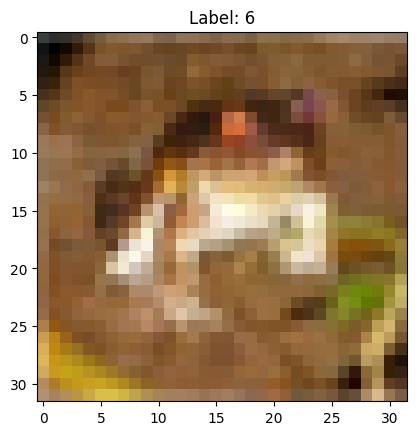

In [40]:
import matplotlib.pyplot as plt  # For plotting and image visualization

# Display the first image in the batch
plt.imshow(X[0])
# X[0] is a NumPy array of shape (32, 32, 3) representing one RGB image.

plt.title(f"Label: {Y[0]}")
# Show the numeric label above the image.
# Note: Y[0] is an integer (0–9), which maps to a class like airplane, cat, etc.
# The actual label names (e.g., "airplane") are stored in `batches.meta`
# and can be used for more human-friendly visualization later.

plt.show()
# Render the image on screen.


In [41]:
# Initialize empty lists for training data and labels
X_train, Y_train = [], []

# Loop over the 5 training batches
for i in range(1, 6):
    batch = unpickle(f"cifar-10-batches-py/data_batch_{i}")
    # Load each training batch (10,000 images each, total 50,000 images)

    X = batch[b'data']       # Shape: (10000, 3072) → flattened images
    Y = batch[b'labels']     # List of 10,000 labels (integers 0–9)

    # Reshape to image format (N, 32, 32, 3)
    X = X.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    # Store results
    X_train.append(X)        # Append image batch
    Y_train.extend(Y)        # Extend list of labels

# Combine all batches into single NumPy arrays
X_train = np.concatenate(X_train)   # Shape: (50000, 32, 32, 3)
Y_train = np.array(Y_train)         # Shape: (50000,)

# Load the test batch (10,000 images)
test_batch = unpickle("cifar-10-batches-py/test_batch")
X_test = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
Y_test = np.array(test_batch[b'labels'])

# Sanity check on dataset sizes
print("Training set:", X_train.shape, Y_train.shape)  # (50000, 32, 32, 3), (50000,)
print("Test set:", X_test.shape, Y_test.shape)        # (10000, 32, 32, 3), (10000,)


Training set: (50000, 32, 32, 3) (50000,)
Test set: (10000, 32, 32, 3) (10000,)


In [42]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# ============================
# Data Transformations
# ============================

# Transformations for training data: includes augmentation
transform_train = transforms.Compose([
    transforms.ToPILImage(),                # Convert NumPy (H,W,C) → PIL image
    transforms.RandomCrop(32, padding=4),   # Random crop with 4px padding (augmentation)
    transforms.RandomHorizontalFlip(),      # Random horizontal flip (augmentation)
    transforms.ToTensor(),                  # Convert PIL image → Torch tensor [0,1]
    transforms.Normalize((0.4914, 0.4822, 0.4465),   # Normalize with dataset mean
                         (0.2023, 0.1994, 0.2010))   # Normalize with dataset std
])

# Transformations for test data: no augmentation, only normalization
transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# ============================
# Custom CIFAR-10 Dataset
# ============================
class CIFARDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images          # Store all images (NumPy array, shape: N x 32 x 32 x 3)
        self.labels = labels          # Store all labels (NumPy array, shape: N,)
        self.transform = transform    # Store transform pipeline (if any)

    def __len__(self):
        return len(self.images)       # Return number of samples in dataset

    def __getitem__(self, idx):
        img = self.images[idx]        # Get image at index `idx`
        label = self.labels[idx]      # Get label at index `idx`

        if self.transform:            # If transformations are defined, apply them
            img = self.transform(img)

        return img, label             # Return transformed image + label
        # img → Tensor of shape (3, 32, 32)
        # label → Integer (0–9)

# ============================
# Dataset + DataLoader Setup
# ============================

# Wrap NumPy arrays into Dataset objects
train_dataset = CIFARDataset(X_train, Y_train, transform=transform_train)
test_dataset  = CIFARDataset(X_test, Y_test, transform=transform_test)

# DataLoader → Provides batches of data for training/testing
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
# - batch_size=128 → each batch has 128 images
# - shuffle=True   → randomize order for training
# - num_workers=2  → number of subprocesses for loading data

test_loader  = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)
# - batch_size=100 → test with 100 images per batch
# - shuffle=False  → test data should not be shuffled

# ============================
# Sanity Check: Inspect One Batch
# ============================
images, labels = next(iter(train_loader))   # Fetch one batch from train_loader
print("Batch shape:", images.shape)         # Expected: (128, 3, 32, 32)
print("Labels:", labels[:10])               # Print first 10 labels in the batch


Batch shape: torch.Size([128, 3, 32, 32])
Labels: tensor([6, 5, 4, 3, 5, 7, 6, 2, 6, 9])


In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ==========================
# 1. Plain CNN (no skip connections)
# ==========================
class PlainCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(PlainCNN, self).__init__()

        # Feature extractor: stack of Conv → BN → ReLU layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # Input: (3, 32, 32), Output: (64, 32, 32)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # (128, 32, 32)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # Downsample: (128, 16, 16)

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # (256, 16, 16)
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # Downsample: (256, 8, 8)

            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # (512, 8, 8)
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # Downsample: (512, 4, 4)
        )

        # Fully connected layer for classification
        self.classifier = nn.Linear(512 * 4 * 4, num_classes)

    def forward(self, x):
        x = self.features(x)                 # Extract features
        x = x.view(x.size(0), -1)            # Flatten to (batch_size, 512*4*4)
        x = self.classifier(x)               # Linear classification layer
        return x


# ==========================
# 2. Residual Block (used in ResNet)
# ==========================
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()

        # First convolution
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Second convolution
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # If dimensions don’t match (e.g., channels or stride), apply downsampling
        self.downsample = downsample

    def forward(self, x):
        identity = x  # Save input for skip connection

        # Main path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Adjust input if needed (downsample)
        if self.downsample is not None:
            identity = self.downsample(x)

        # Add skip connection
        out += identity
        out = self.relu(out)  # Apply activation after addition
        return out


# ==========================
# 3. ResNet (small version for CIFAR-10)
# ==========================
class ResNetSmall(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNetSmall, self).__init__()

        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Residual layers (each has multiple residual blocks)
        self.layer1 = self._make_layer(64, 64, num_blocks=2, stride=1)   # Output: (64, 32, 32)
        self.layer2 = self._make_layer(64, 128, num_blocks=2, stride=2)  # Output: (128, 16, 16)
        self.layer3 = self._make_layer(128, 256, num_blocks=2, stride=2) # Output: (256, 8, 8)
        self.layer4 = self._make_layer(256, 512, num_blocks=2, stride=2) # Output: (512, 4, 4)

        # Global average pooling → FC layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Reduce to (512, 1, 1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        """
        Build a sequence of residual blocks.
        Handles downsampling when dimensions change.
        """
        downsample = None
        if stride != 1 or in_channels != out_channels:
            # Adjust channel size and/or spatial resolution
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        # First block may need downsampling
        layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))
        # Remaining blocks just stack without downsampling
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial conv
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        # Residual layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Pool + Flatten + FC
        x = self.avgpool(x)              # (512, H, W) → (512, 1, 1)
        x = torch.flatten(x, 1)          # (batch_size, 512)
        x = self.fc(x)                   # Linear classifier
        return x


# ==========================
# 4. Test both models
# ==========================
if __name__ == "__main__":
    x = torch.randn(4, 3, 32, 32)  # Dummy input (batch=4, 3x32x32 image)

    plain = PlainCNN()
    resnet = ResNetSmall()

    # Both should output (batch_size, num_classes=10)
    print("Plain CNN output shape:", plain(x).shape)   # (4, 10)
    print("ResNet output shape:", resnet(x).shape)     # (4, 10)


Plain CNN output shape: torch.Size([4, 10])
ResNet output shape: torch.Size([4, 10])


In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # for progress bar

# ==================================
# 1. Training & Evaluation Functions
# ==================================
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, targets in tqdm(dataloader, desc="Training", leave=False):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Evaluating", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


# ==================================
# 2. Full Training Loop
# ==================================
def train_model(model, trainloader, testloader, device, epochs=50, lr=0.1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce LR

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        print(f"\nEpoch [{epoch+1}/{epochs}]")

        train_loss, train_acc = train_one_epoch(model, trainloader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, testloader, criterion, device)

        scheduler.step()

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.2f}%")

    return history


In [45]:
import torch.optim as optim          # optimizer functions (SGD, Adam, etc.)
from tqdm import tqdm                # progress bar for training

# ==================================
# 1. Training Function (one epoch)
# ==================================
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """
    Trains the model for one epoch.

    Args:
        model: The PyTorch model (PlainCNN or ResNet).
        dataloader: Training data loader.
        criterion: Loss function (CrossEntropyLoss).
        optimizer: Optimizer (SGD, Adam, etc.).
        device: 'cuda' or 'cpu'.

    Returns:
        epoch_loss: Average training loss for the epoch.
        epoch_acc: Training accuracy (%) for the epoch.
    """
    model.train()  # set model to training mode (activates dropout/batchnorm updates)
    running_loss, correct, total = 0.0, 0, 0  # stats

    # iterate through mini-batches
    for inputs, targets in tqdm(dataloader, desc="Training", leave=False):
        # move data to GPU/CPU
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()           # clear gradients
        outputs = model(inputs)         # forward pass
        loss = criterion(outputs, targets)  # compute loss
        loss.backward()                 # backpropagation
        optimizer.step()                # update weights

        # accumulate stats
        running_loss += loss.item() * inputs.size(0)  # batch loss * batch size
        _, predicted = outputs.max(1)                 # predicted class index
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item() # correct predictions

    # average loss and accuracy for the epoch
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


# ==================================
# 2. Evaluation Function (validation/test)
# ==================================
def evaluate(model, dataloader, criterion, device):
    """
    Evaluates the model (no gradient updates).

    Args:
        model: The trained model.
        dataloader: Validation/test data loader.
        criterion: Loss function.
        device: 'cuda' or 'cpu'.

    Returns:
        epoch_loss: Average validation/test loss.
        epoch_acc: Validation/test accuracy (%).
    """
    model.eval()  # evaluation mode (disable dropout/batchnorm updates)
    running_loss, correct, total = 0.0, 0, 0

    # disable gradients (faster, saves memory)
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Evaluating", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


# ==================================
# 3. Full Training Loop (multiple epochs)
# ==================================
def train_model(model, trainloader, testloader, device, epochs=50, lr=0.1):
    """
    Trains the model for multiple epochs and evaluates after each epoch.

    Args:
        model: The CNN/ResNet model to train.
        trainloader: Training DataLoader.
        testloader: Validation/Test DataLoader.
        device: 'cuda' or 'cpu'.
        epochs: Number of training epochs.
        lr: Learning rate.

    Returns:
        history: Dictionary containing training/validation loss and accuracy curves.
    """
    criterion = nn.CrossEntropyLoss()  # classification loss
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    # momentum helps faster convergence, weight_decay = L2 regularization

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
    # reduces LR by 10x every 20 epochs

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        print(f"\nEpoch [{epoch+1}/{epochs}]")

        # train for one epoch
        train_loss, train_acc = train_one_epoch(model, trainloader, criterion, optimizer, device)

        # evaluate on validation/test set
        val_loss, val_acc = evaluate(model, testloader, criterion, device)

        # step the LR scheduler
        scheduler.step()

        # store stats
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # display epoch results
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.2f}%")

    return history


In [46]:
from tqdm import tqdm  # progress bar for training/evaluation loops

# ============================
# 1. Helper: Unpickle CIFAR-10 batches
# ============================
def unpickle(file):
    """
    Load CIFAR-10 dataset batch file.

    Args:
        file (str): Path to CIFAR-10 batch file.
    Returns:
        dict: Contains raw image data and labels.
    """
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')  # load Python dict
    return dict


# ============================
# 2. Load CIFAR-10 Training Data
# ============================
X_train, Y_train = [], []  # store all training images and labels

# CIFAR-10 has 5 training batches, each with 10,000 images
for i in range(1, 6):
    batch = unpickle(f"cifar-10-batches-py/data_batch_{i}")  # load one batch
    X = batch[b'data']     # shape (10000, 3072) → flattened 32x32x3
    Y = batch[b'labels']   # list of labels (0–9)

    # Reshape to (N, 32, 32, 3) → format suitable for visualization/processing
    X = X.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    X_train.append(X)      # accumulate batch images
    Y_train.extend(Y)      # accumulate batch labels

# Merge all 5 batches → complete training set
X_train = np.concatenate(X_train)  # shape: (50000, 32, 32, 3)
Y_train = np.array(Y_train)        # shape: (50000,)


# ============================
# 3. Load CIFAR-10 Test Data
# ============================
test_batch = unpickle("cifar-10-batches-py/test_batch")
X_test = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
Y_test = np.array(test_batch[b'labels'])  # shape: (10000,)


# ============================
# 4. Define Transformations
# ============================
# Data augmentation + normalization (training)
transform_train = transforms.Compose([
    transforms.ToPILImage(),                # numpy array → PIL image
    transforms.RandomCrop(32, padding=4),   # random crop with padding
    transforms.RandomHorizontalFlip(),      # random left/right flip
    transforms.ToTensor(),                  # PIL image → tensor [0,1]
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # normalize (per-channel mean/std)
                         (0.2023, 0.1994, 0.2010))
])

# Only normalization (test)
transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])


# ============================
# 5. Custom Dataset Class
# ============================
class CIFARDataset(Dataset):
    """
    Custom Dataset for CIFAR-10 stored as numpy arrays.
    """

    def __init__(self, images, labels, transform=None):
        self.images = images   # numpy array (N, 32, 32, 3)
        self.labels = labels   # numpy array (N,)
        self.transform = transform  # optional preprocessing

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Fetch one image and label
        img = self.images[idx]
        label = self.labels[idx]

        # Apply transformation if defined
        if self.transform:
            img = self.transform(img)

        return img, label


# ============================
# 6. Wrap Data into PyTorch DataLoader
# ============================
train_dataset = CIFARDataset(X_train, Y_train, transform=transform_train)
test_dataset = CIFARDataset(X_test, Y_test, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)


# ============================
# 7. Select Device (GPU if available)
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [47]:
# ============================
# 1. Initialize Plain CNN Model
# ============================
# Create an instance of PlainCNN (defined earlier).
# `.to(device)` moves the model to GPU if available, otherwise CPU.
plain_model = PlainCNN().to(device)

# ============================
# 2. Train the Plain CNN
# ============================
# We call the training function defined earlier (`train_model`)
# with the following parameters:
#   - plain_model: our CNN without skip connections
#   - train_loader: DataLoader for training set
#   - test_loader: DataLoader for validation/test set
#   - device: 'cuda' (GPU) or 'cpu'
#   - epochs: number of full training cycles over dataset (50 here)
#   - lr: learning rate for optimizer (0.1 is a standard starting point for SGD)
#
# The function will:
#   - Train the model epoch by epoch
#   - Evaluate performance after each epoch
#   - Adjust learning rate using StepLR scheduler
#   - Save history of loss/accuracy for plotting later
history_plain = train_model(
    plain_model,
    train_loader,
    test_loader,
    device,
    epochs=50,
    lr=0.1
)



Epoch [1/50]


Train Loss: 3.7348, Train Acc: 18.69%
Val   Loss: 1.7824, Val   Acc: 33.46%

Epoch [2/50]


Train Loss: 1.7341, Train Acc: 35.95%
Val   Loss: 1.7855, Val   Acc: 37.21%

Epoch [3/50]


Train Loss: 1.5367, Train Acc: 43.34%
Val   Loss: 1.3970, Val   Acc: 50.15%

Epoch [4/50]


Train Loss: 1.3400, Train Acc: 51.69%
Val   Loss: 1.6174, Val   Acc: 47.32%

Epoch [5/50]


Train Loss: 1.1825, Train Acc: 57.77%
Val   Loss: 1.0844, Val   Acc: 62.21%

Epoch [6/50]


Train Loss: 1.0789, Train Acc: 61.78%
Val   Loss: 1.0309, Val   Acc: 63.71%

Epoch [7/50]


Train Loss: 0.9832, Train Acc: 65.46%
Val   Loss: 0.9849, Val   Acc: 65.02%

Epoch [8/50]


Train Loss: 0.9145, Train Acc: 68.13%
Val   Loss: 0.9519, Val   Acc: 65.76%

Epoch [9/50]


Train Loss: 0.8639, Train Acc: 70.02%
Val   Loss: 0.8169, Val   Acc: 72.18%

Epoch [10/50]


Train Loss: 0.8081, Train Acc: 72.08%
Val   Loss: 0.8702, Val   Acc: 70.08%

Epoch [11/50]


Train Loss: 0.7667, Train Acc: 73.52%
Val   Loss: 0.8891, Val   Acc: 70.86%

Epoch [12/50]


Train Loss: 0.7409, Train Acc: 74.34%
Val   Loss: 0.8831, Val   Acc: 71.35%

Epoch [13/50]


Train Loss: 0.7066, Train Acc: 75.58%
Val   Loss: 0.8369, Val   Acc: 72.76%

Epoch [14/50]


Train Loss: 0.6813, Train Acc: 76.45%
Val   Loss: 0.6771, Val   Acc: 76.74%

Epoch [15/50]


Train Loss: 0.6643, Train Acc: 77.07%
Val   Loss: 0.8343, Val   Acc: 72.48%

Epoch [16/50]


Train Loss: 0.6496, Train Acc: 77.63%
Val   Loss: 0.9003, Val   Acc: 71.08%

Epoch [17/50]


Train Loss: 0.6285, Train Acc: 78.48%
Val   Loss: 0.7250, Val   Acc: 76.14%

Epoch [18/50]


Train Loss: 0.6219, Train Acc: 78.60%
Val   Loss: 1.0366, Val   Acc: 70.31%

Epoch [19/50]


Train Loss: 0.6024, Train Acc: 79.27%
Val   Loss: 1.2142, Val   Acc: 66.72%

Epoch [20/50]


Train Loss: 0.5948, Train Acc: 79.74%
Val   Loss: 0.7034, Val   Acc: 77.13%

Epoch [21/50]


Train Loss: 0.4344, Train Acc: 85.17%
Val   Loss: 0.4559, Val   Acc: 84.82%

Epoch [22/50]


Train Loss: 0.3890, Train Acc: 86.79%
Val   Loss: 0.4258, Val   Acc: 85.78%

Epoch [23/50]


Train Loss: 0.3659, Train Acc: 87.62%
Val   Loss: 0.4180, Val   Acc: 86.20%

Epoch [24/50]


Train Loss: 0.3551, Train Acc: 87.80%
Val   Loss: 0.4188, Val   Acc: 86.11%

Epoch [25/50]


Train Loss: 0.3396, Train Acc: 88.41%
Val   Loss: 0.4170, Val   Acc: 86.11%

Epoch [26/50]


Train Loss: 0.3343, Train Acc: 88.58%
Val   Loss: 0.4024, Val   Acc: 86.52%

Epoch [27/50]


Train Loss: 0.3226, Train Acc: 89.00%
Val   Loss: 0.4432, Val   Acc: 85.49%

Epoch [28/50]


Train Loss: 0.3168, Train Acc: 89.04%
Val   Loss: 0.4026, Val   Acc: 86.41%

Epoch [29/50]


Train Loss: 0.3105, Train Acc: 89.48%
Val   Loss: 0.3906, Val   Acc: 86.88%

Epoch [30/50]


Train Loss: 0.3040, Train Acc: 89.65%
Val   Loss: 0.4177, Val   Acc: 86.32%

Epoch [31/50]


Train Loss: 0.2965, Train Acc: 89.75%
Val   Loss: 0.4091, Val   Acc: 86.14%

Epoch [32/50]


Train Loss: 0.2911, Train Acc: 89.99%
Val   Loss: 0.4194, Val   Acc: 86.10%

Epoch [33/50]


Train Loss: 0.2838, Train Acc: 90.30%
Val   Loss: 0.4319, Val   Acc: 86.31%

Epoch [34/50]


Train Loss: 0.2781, Train Acc: 90.36%
Val   Loss: 0.4300, Val   Acc: 86.13%

Epoch [35/50]


Train Loss: 0.2763, Train Acc: 90.46%
Val   Loss: 0.3997, Val   Acc: 86.70%

Epoch [36/50]


Train Loss: 0.2696, Train Acc: 90.76%
Val   Loss: 0.3851, Val   Acc: 87.17%

Epoch [37/50]


Train Loss: 0.2654, Train Acc: 91.02%
Val   Loss: 0.4174, Val   Acc: 86.42%

Epoch [38/50]


Train Loss: 0.2666, Train Acc: 90.98%
Val   Loss: 0.4215, Val   Acc: 86.20%

Epoch [39/50]


Train Loss: 0.2602, Train Acc: 91.14%
Val   Loss: 0.3864, Val   Acc: 87.16%

Epoch [40/50]


Train Loss: 0.2513, Train Acc: 91.44%
Val   Loss: 0.4185, Val   Acc: 86.43%

Epoch [41/50]


Train Loss: 0.2118, Train Acc: 92.89%
Val   Loss: 0.3432, Val   Acc: 88.54%

Epoch [42/50]


Train Loss: 0.2036, Train Acc: 93.36%
Val   Loss: 0.3397, Val   Acc: 88.71%

Epoch [43/50]


Train Loss: 0.1965, Train Acc: 93.57%
Val   Loss: 0.3366, Val   Acc: 88.89%

Epoch [44/50]


Train Loss: 0.1940, Train Acc: 93.69%
Val   Loss: 0.3351, Val   Acc: 88.93%

Epoch [45/50]


Train Loss: 0.1895, Train Acc: 93.75%
Val   Loss: 0.3366, Val   Acc: 88.92%

Epoch [46/50]


Train Loss: 0.1871, Train Acc: 93.82%
Val   Loss: 0.3350, Val   Acc: 89.10%

Epoch [47/50]


Train Loss: 0.1863, Train Acc: 93.87%
Val   Loss: 0.3383, Val   Acc: 88.91%

Epoch [48/50]


Train Loss: 0.1807, Train Acc: 94.10%
Val   Loss: 0.3383, Val   Acc: 88.77%

Epoch [49/50]


Train Loss: 0.1824, Train Acc: 93.96%
Val   Loss: 0.3361, Val   Acc: 89.12%

Epoch [50/50]


Train Loss: 0.1771, Train Acc: 94.12%
Val   Loss: 0.3389, Val   Acc: 89.06%


In [51]:
# ============================
# 1. Initialize ResNet Model
# ============================
# Create an instance of our custom small ResNet (ResNetSmall).
# `.to(device)` ensures the model is placed on the correct device:
#   - GPU ('cuda') if available for faster training
#   - CPU otherwise
resnet_model = ResNetSmall().to(device)

# ============================
# 2. Train the ResNet Model
# ============================
# We now train ResNet using the same `train_model` function.
# Parameters:
#   - resnet_model: the ResNet architecture with skip connections
#   - train_loader: batches of training data
#   - test_loader: batches of test/validation data
#   - device: specifies CPU or GPU for computation
#   - epochs=50: train for 50 full passes through the training set
#   - lr=0.1: learning rate for optimizer (controls step size in weight updates)
#
# Expected:
#   - ResNet typically learns better than Plain CNN
#   - Skip connections help gradients flow, reducing vanishing gradient issues
#   - Training history (loss/accuracy) will be stored in `history_resnet`
history_resnet = train_model(
    resnet_model,
    train_loader,
    test_loader,
    device,
    epochs=50,
    lr=0.1
)



Epoch [1/50]


Train Loss: 1.7848, Train Acc: 34.88%
Val   Loss: 1.5046, Val   Acc: 44.04%

Epoch [2/50]


Train Loss: 1.2756, Train Acc: 53.69%
Val   Loss: 1.0727, Val   Acc: 61.67%

Epoch [3/50]


Train Loss: 0.9929, Train Acc: 64.62%
Val   Loss: 0.9592, Val   Acc: 66.81%

Epoch [4/50]


Train Loss: 0.8472, Train Acc: 69.86%
Val   Loss: 0.8875, Val   Acc: 69.69%

Epoch [5/50]


Train Loss: 0.7181, Train Acc: 75.01%
Val   Loss: 0.7790, Val   Acc: 72.98%

Epoch [6/50]


Train Loss: 0.6325, Train Acc: 78.10%
Val   Loss: 0.7545, Val   Acc: 73.81%

Epoch [7/50]


Train Loss: 0.5723, Train Acc: 80.48%
Val   Loss: 0.7765, Val   Acc: 74.22%

Epoch [8/50]


Train Loss: 0.5359, Train Acc: 81.68%
Val   Loss: 0.6288, Val   Acc: 78.91%

Epoch [9/50]


Train Loss: 0.5102, Train Acc: 82.56%
Val   Loss: 0.7474, Val   Acc: 75.58%

Epoch [10/50]


Train Loss: 0.4870, Train Acc: 83.09%
Val   Loss: 0.8514, Val   Acc: 72.26%

Epoch [11/50]


Train Loss: 0.4738, Train Acc: 83.71%
Val   Loss: 0.5846, Val   Acc: 80.25%

Epoch [12/50]


Train Loss: 0.4601, Train Acc: 84.20%
Val   Loss: 0.5226, Val   Acc: 82.34%

Epoch [13/50]


Train Loss: 0.4458, Train Acc: 84.70%
Val   Loss: 0.6863, Val   Acc: 78.31%

Epoch [14/50]


Train Loss: 0.4291, Train Acc: 85.42%
Val   Loss: 0.8041, Val   Acc: 73.65%

Epoch [15/50]


Train Loss: 0.4169, Train Acc: 85.73%
Val   Loss: 0.6059, Val   Acc: 80.86%

Epoch [16/50]


Train Loss: 0.4152, Train Acc: 85.79%
Val   Loss: 0.5624, Val   Acc: 81.92%

Epoch [17/50]


Train Loss: 0.4031, Train Acc: 86.14%
Val   Loss: 0.5014, Val   Acc: 83.33%

Epoch [18/50]


Train Loss: 0.3969, Train Acc: 86.40%
Val   Loss: 0.6691, Val   Acc: 79.00%

Epoch [19/50]


Train Loss: 0.3937, Train Acc: 86.52%
Val   Loss: 0.7212, Val   Acc: 77.00%

Epoch [20/50]


Train Loss: 0.3883, Train Acc: 86.81%
Val   Loss: 0.5025, Val   Acc: 83.44%

Epoch [21/50]


Train Loss: 0.2304, Train Acc: 92.25%
Val   Loss: 0.2538, Val   Acc: 91.30%

Epoch [22/50]


Train Loss: 0.1777, Train Acc: 93.93%
Val   Loss: 0.2455, Val   Acc: 91.85%

Epoch [23/50]


Train Loss: 0.1535, Train Acc: 94.94%
Val   Loss: 0.2360, Val   Acc: 92.17%

Epoch [24/50]


Train Loss: 0.1388, Train Acc: 95.29%
Val   Loss: 0.2341, Val   Acc: 92.05%

Epoch [25/50]


Train Loss: 0.1262, Train Acc: 95.72%
Val   Loss: 0.2481, Val   Acc: 91.98%

Epoch [26/50]


Train Loss: 0.1157, Train Acc: 96.04%
Val   Loss: 0.2483, Val   Acc: 92.21%

Epoch [27/50]


Train Loss: 0.1056, Train Acc: 96.42%
Val   Loss: 0.2417, Val   Acc: 92.26%

Epoch [28/50]


Train Loss: 0.1002, Train Acc: 96.62%
Val   Loss: 0.2507, Val   Acc: 92.21%

Epoch [29/50]


Train Loss: 0.0895, Train Acc: 97.02%
Val   Loss: 0.2407, Val   Acc: 92.45%

Epoch [30/50]


Train Loss: 0.0835, Train Acc: 97.18%
Val   Loss: 0.2485, Val   Acc: 92.47%

Epoch [31/50]


Train Loss: 0.0763, Train Acc: 97.44%
Val   Loss: 0.2525, Val   Acc: 92.42%

Epoch [32/50]


Train Loss: 0.0754, Train Acc: 97.47%
Val   Loss: 0.2655, Val   Acc: 92.04%

Epoch [33/50]


Train Loss: 0.0705, Train Acc: 97.61%
Val   Loss: 0.2552, Val   Acc: 92.36%

Epoch [34/50]


Train Loss: 0.0675, Train Acc: 97.66%
Val   Loss: 0.2732, Val   Acc: 91.91%

Epoch [35/50]


Train Loss: 0.0683, Train Acc: 97.70%
Val   Loss: 0.2476, Val   Acc: 92.58%

Epoch [36/50]


Train Loss: 0.0649, Train Acc: 97.78%
Val   Loss: 0.2605, Val   Acc: 92.34%

Epoch [37/50]


Train Loss: 0.0613, Train Acc: 97.96%
Val   Loss: 0.2973, Val   Acc: 91.75%

Epoch [38/50]


Train Loss: 0.0622, Train Acc: 97.90%
Val   Loss: 0.3530, Val   Acc: 90.23%

Epoch [39/50]


Train Loss: 0.0609, Train Acc: 97.93%
Val   Loss: 0.2540, Val   Acc: 92.86%

Epoch [40/50]


Train Loss: 0.0573, Train Acc: 98.09%
Val   Loss: 0.2666, Val   Acc: 92.24%

Epoch [41/50]


Train Loss: 0.0346, Train Acc: 98.96%
Val   Loss: 0.2261, Val   Acc: 93.44%

Epoch [42/50]


Train Loss: 0.0258, Train Acc: 99.30%
Val   Loss: 0.2240, Val   Acc: 93.50%

Epoch [43/50]


Train Loss: 0.0199, Train Acc: 99.48%
Val   Loss: 0.2241, Val   Acc: 93.53%

Epoch [44/50]


Train Loss: 0.0186, Train Acc: 99.54%
Val   Loss: 0.2236, Val   Acc: 93.57%

Epoch [45/50]


Train Loss: 0.0173, Train Acc: 99.57%
Val   Loss: 0.2263, Val   Acc: 93.62%

Epoch [46/50]


Train Loss: 0.0157, Train Acc: 99.61%
Val   Loss: 0.2261, Val   Acc: 93.54%

Epoch [47/50]


Train Loss: 0.0143, Train Acc: 99.69%
Val   Loss: 0.2248, Val   Acc: 93.67%

Epoch [48/50]


Train Loss: 0.0142, Train Acc: 99.68%
Val   Loss: 0.2260, Val   Acc: 93.68%

Epoch [49/50]


Train Loss: 0.0128, Train Acc: 99.75%
Val   Loss: 0.2265, Val   Acc: 93.62%

Epoch [50/50]


Train Loss: 0.0126, Train Acc: 99.73%
Val   Loss: 0.2290, Val   Acc: 93.70%


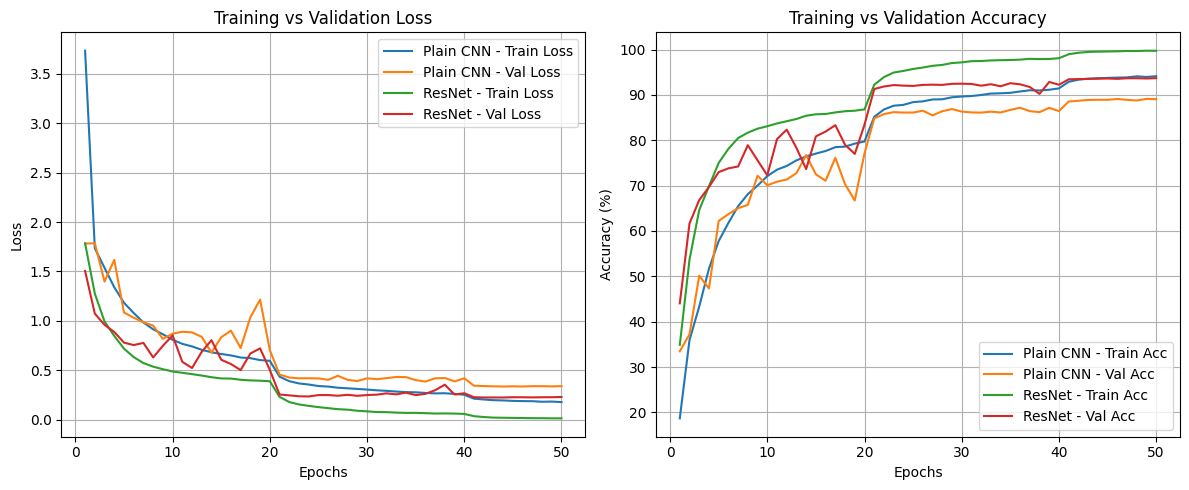

In [53]:
def plot_training_curves(history_plain, history_resnet):
    """
    Plot training and validation curves for Plain CNN vs ResNet models.

    Args:
        history_plain (dict): Contains training/validation loss & accuracy for Plain CNN
        history_resnet (dict): Contains training/validation loss & accuracy for ResNet
    """

    # X-axis: Epoch numbers (1 → N)
    epochs = range(1, len(history_plain["train_loss"]) + 1)

    # ==========================
    # 1. Plot Training & Validation Loss
    # ==========================
    plt.figure(figsize=(12, 5))  # create a wide figure with 2 subplots

    # --- Left subplot: Loss ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_plain["train_loss"], label="Plain CNN - Train Loss")
    plt.plot(epochs, history_plain["val_loss"], label="Plain CNN - Val Loss")
    plt.plot(epochs, history_resnet["train_loss"], label="ResNet - Train Loss")
    plt.plot(epochs, history_resnet["val_loss"], label="ResNet - Val Loss")
    plt.xlabel("Epochs")                # label for x-axis
    plt.ylabel("Loss")                  # label for y-axis
    plt.title("Training vs Validation Loss")  # subplot title
    plt.legend()                        # show legend to distinguish models
    plt.grid(True)                      # enable grid for clarity

    # ==========================
    # 2. Plot Training & Validation Accuracy
    # ==========================
    # --- Right subplot: Accuracy ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_plain["train_acc"], label="Plain CNN - Train Acc")
    plt.plot(epochs, history_plain["val_acc"], label="Plain CNN - Val Acc")
    plt.plot(epochs, history_resnet["train_acc"], label="ResNet - Train Acc")
    plt.plot(epochs, history_resnet["val_acc"], label="ResNet - Val Acc")
    plt.xlabel("Epochs")                       # label for x-axis
    plt.ylabel("Accuracy (%)")                 # label for y-axis
    plt.title("Training vs Validation Accuracy")  # subplot title
    plt.legend()                               # legend to compare models
    plt.grid(True)                             # enable grid

    # ==========================
    # 3. Final Layout Adjustment
    # ==========================
    plt.tight_layout()  # adjust spacing between subplots for readability
    plt.show()          # display the figure

plot_training_curves(history_plain, history_resnet)


In [54]:
# ==========================
# 1. Print Final Validation Results
# ==========================
def compare_results(history_plain, history_resnet):
    """
    Compare the final validation accuracy of Plain CNN and ResNet models.

    Args:
        history_plain (dict): Training history dictionary for Plain CNN
        history_resnet (dict): Training history dictionary for ResNet
    """

    # Extract the last recorded validation accuracy for each model
    plain_final_acc = history_plain["val_acc"][-1]
    resnet_final_acc = history_resnet["val_acc"][-1]

    # Print side-by-side comparison
    print("===== Final Validation Accuracy =====")
    print(f"Plain CNN : {plain_final_acc:.2f}%")
    print(f"ResNet    : {resnet_final_acc:.2f}%")

    # Highlight which model performs better
    if resnet_final_acc > plain_final_acc:
        print("\n✅ ResNet performs better (higher accuracy, better convergence).")
    else:
        print("\n⚠️ Plain CNN surprisingly matched or outperformed ResNet. "
              "Consider tuning hyperparameters or training longer.")


# ==========================
# 2. Confusion Matrix Plot
# ==========================
def plot_confusion_matrix(model, dataloader, device, classes):
    """
    Generate and display the confusion matrix for a trained model.

    Args:
        model (torch.nn.Module): Trained model (Plain CNN or ResNet)
        dataloader (DataLoader): DataLoader for test/validation dataset
        device (torch.device): 'cuda' or 'cpu' device for inference
        classes (list): List of class names for CIFAR-10
    """

    # Put the model in evaluation mode (disables dropout, batch norm updates)
    model.eval()

    # Containers for predictions and ground-truth labels
    all_preds, all_labels = [], []

    # Disable gradient calculations (saves memory & computation during inference)
    with torch.no_grad():
        for inputs, labels in dataloader:
            # Move inputs and labels to GPU/CPU
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Get the predicted class (index with max probability)
            _, preds = outputs.max(1)

            # Collect predictions & labels into Python lists
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Create a ConfusionMatrixDisplay object for visualization
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

    # Plot confusion matrix with blue color map
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)

    # Add a descriptive title
    plt.title("Confusion Matrix")
    plt.show()


===== Final Validation Accuracy =====
Plain CNN : 89.06%
ResNet    : 93.70%

✅ ResNet performs better (higher accuracy, better convergence).

Plain CNN Confusion Matrix:


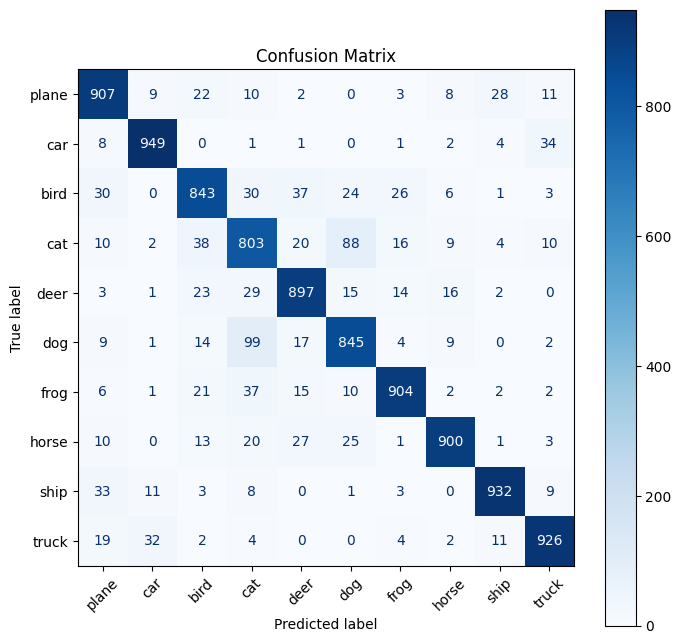


ResNet Confusion Matrix:


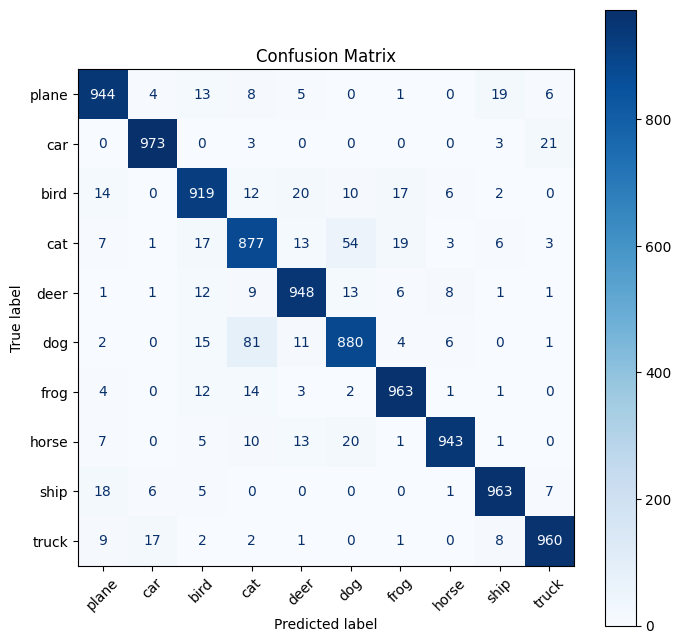

In [55]:
# ==========================
# 1. Define CIFAR-10 Class Labels
# ==========================
classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)
# These labels correspond to the CIFAR-10 dataset classes in order (0–9).


# ==========================
# 2. Re-create Test DataLoader
# ==========================
# We re-define `test_loader` here to ensure it's available in this cell.
# Using the same `CIFARDataset` class and `transform_test` defined earlier.

test_dataset = CIFARDataset(X_test, Y_test, transform=transform_test)

# DataLoader wraps the dataset into mini-batches for efficient iteration.
# - batch_size=100 → processes 100 test images at once
# - shuffle=False  → order does not matter for evaluation
# - num_workers=2  → parallel data loading with 2 worker threads
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)


# ==========================
# 3. Compare Final Model Accuracies
# ==========================
# This will print the final validation accuracy of both models
# (Plain CNN vs ResNet) using results from the training history.
compare_results(history_plain, history_resnet)


# ==========================
# 4. Plot Confusion Matrices
# ==========================
# A confusion matrix shows where the model makes mistakes:
# - Rows: Actual (true) labels
# - Columns: Predicted labels

print("\nPlain CNN Confusion Matrix:")
plot_confusion_matrix(plain_model, test_loader, device, classes)

print("\nResNet Confusion Matrix:")
plot_confusion_matrix(resnet_model, test_loader, device, classes)
